# Exploración de los datos

In [63]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


El caso de negocio: Una importante productora quiere asistir a sus guionistas proporcionandoles información que les permita anticiparse a caracteristicas claves que deteminan el exito de una pelicula.

In [64]:
from pathlib import Path

In [65]:
import matplotlib.pyplot as plt
import numpy as np

PATH = Path('/content/gdrive/MyDrive/data')

In [66]:
list(PATH.glob('*'))

[PosixPath('/content/gdrive/MyDrive/data/aclImdb_v1.tar.gz'),
 PosixPath('/content/gdrive/MyDrive/data/title.basics.tsv.gz'),
 PosixPath('/content/gdrive/MyDrive/data/title.ratings.tsv.gz'),
 PosixPath('/content/gdrive/MyDrive/data/title.crew.tsv.gz'),
 PosixPath('/content/gdrive/MyDrive/data/title.principals.tsv.gz'),
 PosixPath('/content/gdrive/MyDrive/data/title.akas.tsv.gz'),
 PosixPath('/content/gdrive/MyDrive/data/movie_metadata.csv')]

Arrancamos por title basics
Ver documentacion de columnas aca:https://www.imdb.com/interfaces/



Tomo el Data set Title Basics

In [67]:
import pandas as pd

title_basics = pd.read_csv(PATH / 'title.basics.tsv.gz', sep='\t')
#import gzip
#title_basics = gzip.open(PATH / 'title.basics.tsv.gz', 'rb')
len(title_basics)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


7360387

Tengo mas de 7 millones de datos. El archivo tsv significa que esta separado por espacios

# A ver algunas **rows** 

In [68]:
title_basics.dtypes

tconst            object
titleType         object
primaryTitle      object
originalTitle     object
isAdult            int64
startYear         object
endYear           object
runtimeMinutes    object
genres            object
dtype: object

### titleType

In [69]:
title_basics.titleType.value_counts()

tvEpisode       5309219
short            779055
movie            559578
video            286901
tvSeries         196364
tvMovie          111544
tvMiniSeries      34353
tvSpecial         30347
videoGame         26795
tvShort           26228
episode               1
audiobook             1
radioSeries           1
Name: titleType, dtype: int64

Dentro del 'Explore the Data' Descartamos algunos (no aplican para lo que estamos trabajando ahora)
el código con ~ y isin es complejo de entender:
leamos el código desde adentro hacia afuera, del total --> todas las que esten en .isin (las que quiero quitar) y con ~ las quito del total.

In [70]:
title_basics = title_basics[
    # Dejamos movie, tvSpecial, video y tvMovie por ahora, vamos a ver de que se tratan
    ~title_basics.titleType.isin(['tvEpisode', 'tvSeries', 'tvMiniSeries', 'videoGame', 'tvShort', 'short'])
]

len(title_basics) # vemos con cuanta data nos quedamos

988373

In [72]:
title_basics.titleType.value_counts()

movie          559578
video          286901
tvMovie        111544
tvSpecial       30347
audiobook           1
episode             1
radioSeries         1
Name: titleType, dtype: int64

La cantidad de datos bajo sensiblemente

In [73]:
title_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
331,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,\N,"Biography,Drama"
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Biography,Crime,Drama"
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama


Fijarse en: runtimeMinutes '\N'. Lo pasaremos a tipo: Not a number

In [74]:
# Convertimos runtimeMinutes a float. No se puede tener una columna de tipo int con NaN. lo pasamos a np.nan que quiere decir not a number.
title_basics.runtimeMinutes = (
    title_basics.runtimeMinutes.apply(lambda x: np.nan if x == r'\N' else x).astype(float)
)

Un float en python es un tipo de variable que permite guardar numeros reales, a diferencia de un "int" (un int es tipo de variable que guarda números entero) este puede contener decimales, ejemplo de floats: 3.1415.

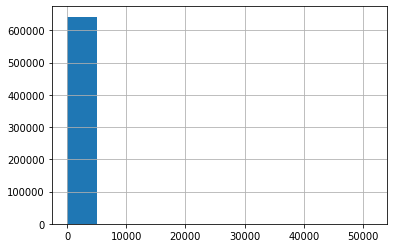

In [75]:
title_basics.runtimeMinutes.dropna().hist();

Intentamos hacer un histograma, pero no se ve nada. Parece tener algunos valores muy grandes

In [76]:
title_basics.sort_values('runtimeMinutes', ascending=False).head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
6584056,tt8273150,movie,Logistics,Logistics,0,2012,\N,51420.0,Documentary
2165876,tt12095652,video,The Longest Video on YouTube: 596.5 Hours,The Longest Video on YouTube: 596.5 Hours,0,2011,\N,35791.0,\N
2268972,tt12277054,movie,Carnets Filmés (Liste Complète),Carnets Filmés (Liste Complète),0,2019,\N,28643.0,Documentary
4066004,tt2659636,movie,Modern Times Forever,Modern Times Forever,0,2011,\N,14400.0,Documentary
1943403,tt11707418,tvMovie,Svalbard Minute by Minute,Svalbard minutt for minutt,0,2020,\N,13319.0,"Adventure,Documentary"


Efectivamente hay valores enormes. runtimeMinutes = 13319 quiere decir 221 horas!!!!.

Garbage in garbage out. Tengo que revisar bien los datos porque sin un correcto preprocesado el modelo me dara malos resultados.

**Cuantas peliculas de mas de 3 horas hay?**

In [77]:
(title_basics.runtimeMinutes > 3 * 60).sum() / len(title_basics)

0.009385120799536208

In [78]:
title_basics.dtypes

tconst             object
titleType          object
primaryTitle       object
originalTitle      object
isAdult             int64
startYear          object
endYear            object
runtimeMinutes    float64
genres             object
dtype: object

Descartamos las series (no aplican para lo que estamos trabajando ahora), video tambien la quitaria. 

In [79]:
title_basics = title_basics[
    # Dejamos tvSpecial, video y tvMovie por ahora, vamos a ver de que se tratan
    ~title_basics.titleType.isin(['tvEpisode', 'video','tvSeries', 'tvMiniSeries', 'videoGame', 'tvShort', 'short'])
]

len(title_basics) # vemos con cuanta data nos quedamos

701472

En consecuencia, ahora tenemos aproximadamente 700 mil datos (solo el 10% del data set original), elegir con que datos seguir trabajando no es tarea fácil, para ello hay que tener presente la visión del negocio.

In [80]:
title_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45.0,Romance
331,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,NaN,"Biography,Drama"
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100.0,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70.0,"Biography,Crime,Drama"
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,NaN,Drama


## runtimeMinutes

In [81]:
title_basics.runtimeMinutes

8           45.0
331          NaN
498        100.0
570         70.0
610          NaN
           ...  
7360303    100.0
7360308     66.0
7360315      NaN
7360326    116.0
7360337     49.0
Name: runtimeMinutes, Length: 701472, dtype: float64

In [82]:
title_basics[title_basics.runtimeMinutes == r'NaN'].head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres


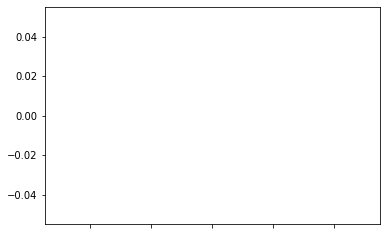

In [114]:
title_basics[
        (title_basics.runtimeMinutes == r'NaN') &
        (title_basics.startYear != r'NaN')
].startYear.apply(int).value_counts().sort_index().plot()

In [84]:
title_basics[title_basics.runtimeMinutes > 3 * 60].sample(20)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
1983467,tt11777298,movie,DAU. Degeneratsiya,DAU. Degeneratsiya,0,2020,\N,369.0,"Drama,Horror,Thriller"
3571253,tt1976520,tvMovie,Anita Garibaldi,Anita Garibaldi,0,2012,\N,198.0,"Biography,Drama,History"
6245971,tt7550296,movie,Mainstream: How Hollywood Movies and the New Y...,Mainstream: How Hollywood Movies and the New Y...,0,2017,\N,208.0,Documentary
5237728,tt5335720,movie,"Animitas, 2014","Animitas, 2014",0,2015,\N,720.0,Documentary
193057,tt0200638,tvMovie,Les filles du maître de chai,Les filles du maître de chai,0,1997,\N,271.0,"Drama,Romance"
75538,tt0077138,movie,The Tree of Wooden Clogs,L'albero degli zoccoli,0,1978,\N,186.0,"Drama,History"
2067510,tt1192353,tvSpecial,1983 MLB All-Star Game,1983 MLB All-Star Game,0,1983,\N,185.0,Sport
2354606,tt12427962,movie,Neil Breen's 5 Film Retrospective,Neil Breen's 5 Film Retrospective,0,2020,\N,340.0,Documentary
6965293,tt9085374,movie,Light Years,Light Years,0,2018,\N,193.0,\N
2907664,tt13394274,movie,Raattinam,Raattinam,0,2012,\N,202.0,Drama


Parece haber muchos video

In [85]:
title_basics[title_basics.runtimeMinutes > 3 * 60].titleType.value_counts()

movie        2027
tvMovie      1162
tvSpecial     788
Name: titleType, dtype: int64

Pareciera que hay muchos videos, tvMovie y tvSpecial

Por otro lado, alguna de estas estará en la base de datos de grossing? Ya que estamos, tambien podemos juntarla con la de ratings

## Merges para ver una foto mas completa

In [86]:
movie_gross = pd.read_csv(PATH / 'movie_metadata.csv')

En terminos practicos es la recaudación: Lo que quiero buscar hacer es predecir el gross, la recaudación, de una pelicula. Seria hacer una regresión al gross. 

In [87]:
movie_gross.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [88]:
len(movie_gross)

5043

In [89]:
movie_gross.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [90]:
# No tenemos el id, pero tenemos el link
movie_gross.movie_imdb_link.head()

0    http://www.imdb.com/title/tt0499549/?ref_=fn_t...
1    http://www.imdb.com/title/tt0449088/?ref_=fn_t...
2    http://www.imdb.com/title/tt2379713/?ref_=fn_t...
3    http://www.imdb.com/title/tt1345836/?ref_=fn_t...
4    http://www.imdb.com/title/tt5289954/?ref_=fn_t...
Name: movie_imdb_link, dtype: object

In [91]:
movie_gross['tconst'] = movie_gross.movie_imdb_link.apply(lambda x: x.split('/')[4])

In [92]:
# A priori solo nos interesa el tconst y el gross

movie_gross = movie_gross[['tconst', 'gross']]

In [93]:
movie_gross.head()

,tconst,gross
0,tt0499549,760505847.0
1,tt0449088,309404152.0
2,tt2379713,200074175.0
3,tt1345836,448130642.0
4,tt5289954,NaN


In [94]:
title_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45.0,Romance
331,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,NaN,"Biography,Drama"
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100.0,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70.0,"Biography,Crime,Drama"
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,NaN,Drama


Vamos a mergear (join) las bases de datos con (on) 'tconst'

In [95]:
movies = title_basics.merge(movie_gross, on='tconst')

Junte title_basics con movie_gorss en aquellos que coincide en tconst en el mejor de los casos tenrdia 5043 o en su defecto menos, nunca un número mayor. 

In [96]:
len(movies)

4912

Nótese que en movies se agrego una nueva columna que es 'gross'

In [97]:
movies.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,gross
0,tt0006864,movie,Intolerance: Love's Struggle Throughout the Ages,Intolerance: Love's Struggle Throughout the Ages,0,1916,\N,163.0,"Drama,History",NaN
1,tt0011549,movie,Over the Hill to the Poorhouse,Over the Hill to the Poorhouse,0,1920,\N,110.0,"Crime,Drama",3000000.0
2,tt0015624,movie,The Big Parade,The Big Parade,0,1925,\N,151.0,"Drama,Romance,War",NaN
3,tt0017136,movie,Metropolis,Metropolis,0,1927,\N,153.0,"Drama,Sci-Fi",26435.0
4,tt0018737,movie,Pandora's Box,Die Büchse der Pandora,0,1929,\N,109.0,"Crime,Drama,Romance",9950.0


In [98]:
# Checkeamos no perder datos
len(movies), len(movie_gross), len(title_basics)

(4912, 5043, 701472)

In [99]:
# Perdemos muchos datos.

movies = title_basics.merge(movie_gross, on='tconst', how='left')

In [100]:
len(movies), len(movie_gross), len(title_basics)

(701594, 5043, 701472)

Si yo solo tengo 5 mil peliculas que tengo el Gross, y si tengo ese dato por el motivo 'les fue bien', tengo un problema de sesgo de selección. Puedo controlar el dataset por la distibución de reinting. Es decir, cabe preguntarnos la siguente pregunta, la distibución de rating es igual entre el conjunto de datos para el cual conozco gross y para las que no lo conozco.

Merge con Ratings

In [101]:
title_ratings = pd.read_csv(PATH / 'title.ratings.tsv.gz', sep='\t')

In [102]:
movies_wr = movies.merge(title_ratings, on='tconst')
movies_wr.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,gross,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45.0,Romance,NaN,6.0,154
1,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,NaN,"Biography,Drama",NaN,6.0,39
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100.0,\N,NaN,4.7,7
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70.0,"Biography,Crime,Drama",NaN,6.1,598
4,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,NaN,Drama,NaN,4.5,14


In [103]:
# Checkeamos que no perdimos data en el join
len(movies_wr), len(movies), len(title_ratings)

(307170, 701594, 1093291)

{'boxes': [<matplotlib.lines.Line2D at 0x7fe804644128>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe804644828>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe8045d7e48>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fe8045d7898>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fe804644550>,
  <matplotlib.lines.Line2D at 0x7fe8045efa20>]}

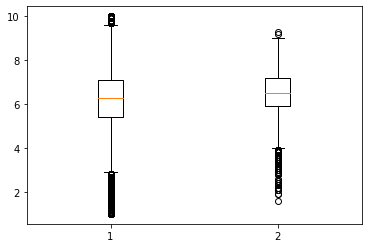

In [104]:
plt.boxplot(
    [movies_wr[movies_wr.gross.isna()].averageRating,
     movies_wr[~movies_wr.gross.isna()].averageRating]
    )
#Recordar que el .isna() te devuelve donde no hay datos
#Cuando no tengo el groos
#Cuando tengo el gross

A priori pareceria ser que la mediana es igual, si hay diferencia en los valores extremos. El boxplot que esta a la izquierda refiere cuando no tengo info de gross y el de la derecha es cuando si tengo esa información. Cuando no tengo la info de gross esta mas dispersa la info asi como hay muchas peliculas con bajo puntaje (si son malas nadie se habra tomado el trabajo de guardar esa info). Al eliminar datos, por ejemplo, las que no tenemos info de gross, ¿que sesgo esta imprimiendo en nuestros datos?, ¿como afectara las decisiones que tomemos?, puede generar que cosas malas pensemos que son buenas porque en realidad el modelo nunca las vio. Tal vez si el modelo logra poder discriminar correctamente o tal vez no. Asumimos el riesgo y luego lo controlamos  o no vamos por este camino. Hay una cantidad considerable de peliculas 'malas' que estan siendo censuradas por gross.

# sanity check

In [105]:
movies[movies.runtimeMinutes > 3 * 60].gross.isna().sum() / n_long

0.9907035175879397

In [106]:
# idem para 2 horas
movies[movies.runtimeMinutes > 2 * 60].gross.isna().sum() / (movies.runtimeMinutes > 2 * 60).sum()

0.9751107531212243

In [107]:
movies = movies[movies.runtimeMinutes <= 2 * 60].copy()

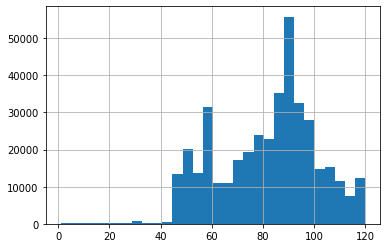

In [108]:
movies.runtimeMinutes.hist(bins=30);

Bastante Bien, coherente con la duracón esperada de una pelicula, se acumula mayor cantidad luego de la hora de duración 

In [109]:
from itertools import chain
from collections import Counter

def parse_genres(genres):
    if isinstance(genres, float) or genres == r'\N': return ['no-genre']
    else: return genres.split(',')
    

movies['genres'] = movies.genres.apply(parse_genres)

In [110]:
Counter(chain(*movies.genres.tolist()))


Counter({'Action': 26443,
         'Adult': 5272,
         'Adventure': 18555,
         'Animation': 5806,
         'Biography': 13512,
         'Comedy': 82088,
         'Crime': 26323,
         'Documentary': 97630,
         'Drama': 144304,
         'Family': 14339,
         'Fantasy': 9192,
         'Film-Noir': 783,
         'Game-Show': 253,
         'History': 10905,
         'Horror': 19782,
         'Music': 15069,
         'Musical': 7147,
         'Mystery': 12021,
         'News': 1949,
         'Reality-TV': 1070,
         'Romance': 30185,
         'Sci-Fi': 7374,
         'Short': 744,
         'Sport': 5778,
         'Talk-Show': 874,
         'Thriller': 23918,
         'War': 6531,
         'Western': 5497,
         'no-genre': 25372})

Okey, me llama la atencón la cantidad de 'no-genre'. Comparemos distribución con algun genero clásico. 

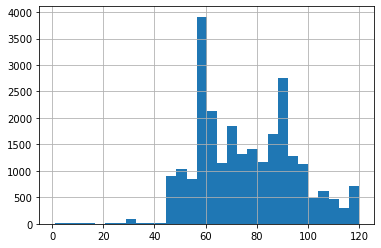

In [111]:
movies[movies.genres.apply(lambda x: 'no-genre' in x)].runtimeMinutes.hist(bins=30);

Me hubiese sonado las alarmas si tuviera una cola a la izquierda

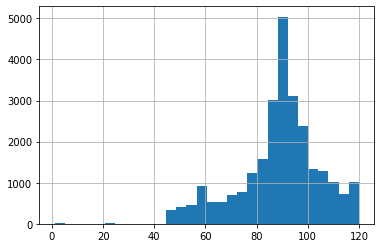

In [112]:
movies[movies.genres.apply(lambda x: 'Action' in x)].runtimeMinutes.hist(bins=30);

En resumen este analisis pretende mostrar como abordar una primera exploración a una base de datos y poder llegar a algun insight de lo como esta la información presentada. Muchas veces con que datos permanecer y con cuales no, es una decisión compleja ya que en ese proceso se pueden incurrir en errores que sesgen nuestras conclusiones. 